<a href="https://colab.research.google.com/github/manuvillalba-uclm/Natural_Lenguaje_Processing-ELM/blob/Preprocessing/Machine_Learning_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TO DO

Dividir el collab en varios, este se mantendría para generear el csv de los tweets pre-procesados y vectorizados.


Los emojis los traduce bien pero no como queremos, nos da igual que nos diga face_with_tears_of_joy, el objetivo es que tears y joy se integren con el texto, eso hay que revisarlo.

No sé hasta que punto nos interesa mantener los hastag




In [1]:
# dataframes library
!pip install pyspellchecker 
!pip install contractions
!pip install nltk --upgrade
!pip install emoji

import pandas as pd
import re
import nltk
nltk.download("popular")
nltk.download('vader_lexicon') #sentiment analysis
nltk.download('twython') #twitter not necessary

from nltk.tokenize.casual import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#Correcciones y emoji
import emoji
from textblob import TextBlob
from spellchecker import SpellChecker
import contractions
from multiprocessing import Pool

#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

#Feature selection 
from sklearn.feature_selection import SelectKBest, chi2

#Classification
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np



Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.5)


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [2]:
english_stops = set(stopwords.words('english'))
spell = SpellChecker()
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()


In [3]:
raw_dataset_tweets = pd.read_csv('https://raw.githubusercontent.com/manuvillalba-uclm/Natural_Lenguaje_Processing-ELM/main/labeled_data.csv?token=ANLXPWL27WHT4VS5U4LHMVK72D27M', index_col=[0])

# Preprocesing:

Mandatory preprocessing steps
 - Remove unseful data: ! "_ $% & / ( ) = _ ˆ* ¡@
 - Remove all capital letters
 - Correct wrong words: https://norvig.com/spell-correct.html
 - Lemmatize all terms

Optional preprocessing steps:
 - Remove contractions: don’t -> do not
 - Remove repeated words: great great show
 - Replace emoticons, for example,🙂 with “smile”, 😉with “ok”


We just need index and tweet content for this first part, so we drop Crowdflowers users information from the dataset.

In [4]:
dataset_tweets_preprocesing = raw_dataset_tweets.copy()
dataset_tweets_preprocesing.drop("count", axis = 1, inplace = True)
dataset_tweets_preprocesing.drop("hate_speech", axis = 1, inplace = True)
dataset_tweets_preprocesing.drop("offensive_language", axis = 1, inplace = True)
dataset_tweets_preprocesing.drop("neither", axis = 1, inplace = True)
dataset_tweets_preprocesing.drop("class", axis = 1, inplace = True)

In [5]:
dataset_tweets_preprocesing

,tweet
0,!!! RT @mayasolovely: As a woman you shouldn't...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...
25291,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,"you've gone and broke the wrong heart baby, an..."
25294,young buck wanna eat!!.. dat nigguh like I ain...
25295,youu got wild bitches tellin you lies


Seleccionamos sólo unos pocos para trabajar al principio más fácilmente

In [6]:
#@title Texto de título predeterminado
num_tweets = 1000 #@param {type:"slider", min:20, max:24783, step:10}

examples_preprocesing = dataset_tweets_preprocesing.iloc[0:num_tweets,0]
examples_preprocesing.reset_index(inplace = True, drop= True)
print(examples_preprocesing)

lista_tweets = []



0      !!! RT @mayasolovely: As a woman you shouldn't...
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                             ...                        
995    &#128514;&#128514;&#128514;&#128514; RT @SMASH...
996    &#128514;&#128514;&#128514;&#128514; bitch if ...
997    &#128514;&#128514;&#128514;&#128514; these fol...
998    &#128514;&#128514;&#128514;&#128514;&#128514; ...
999    &#128514;&#128514;&#128514;&#128514;&#128514;&...
Name: tweet, Length: 1000, dtype: object


### Definimos las funciones que procesarán los tweets


In [7]:
def stopwords(text):
    return " ".join([word for word in str(text).split() if word not in english_stops])

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def demojizar(arr):
    text_arr = []
    for token in arr:
      text_arr.append(emoji.demojize(token, delimiters=("", "")))
    return text_arr

def textConditions(token):
  if re.match("[`!\"_$%&/()=_ˆ*¡,@:.]+",token): #Signos de puntuacion
    return False
  if re.match("[-><~]+",token): #Signos de puntuacion
    return False
  if re.match("[^\u0000-\u007F]+",token): #Unicodes
    return False
  return True

def processArray(arr):
  text_arr = []
  for token in arr:
    if textConditions(token):
      token = stemmer.stem(token)
      token = lemmatizer.lemmatize(token) # < ---- LEMMA
      text_arr.append(token)
  # try: #Aqui iria el tagger de palabras, pero solo me lo hace para letras (ERROR)
  #   arr_tags = nltk.pos_tag(text_arr)
  # except:
  #   arr_tags = text_arr
  return text_arr

In [8]:
%%time

ds_alt_twitter = examples_preprocesing.copy()
ds_alt_twitter = ds_alt_twitter.str.lower() #A minusc
ds_alt_twitter = ds_alt_twitter.apply(contractions.fix) #Arreglar contracciones
ds_alt_twitter = ds_alt_twitter.apply(contractions.fix) #Plural a singular

ds_alt_twitter = ds_alt_twitter.str.replace('(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z0-9_]+[A-Za-z0-9-_]+)','') #Remover usuario
ds_alt_twitter = ds_alt_twitter.str.replace('(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z0-9_]+[A-Za-z0-9-_]+)','') #Remover usuario
ds_alt_twitter = ds_alt_twitter.str.replace('rt','') #Remover rt

ds_alt_twitter = ds_alt_twitter.apply(stopwords) #Quitar Stopwords
ds_alt_twitter = ds_alt_twitter.apply(remove_urls) #Quitar url

ds_alt_twitter = ds_alt_twitter.apply(lambda x: str(TextBlob(x).correct()))
ds_alt_twitter = ds_alt_twitter.apply(TweetTokenizer().tokenize) #Tokenizar
ds_alt_twitter = ds_alt_twitter.apply(demojizar) #Traducir emoji a texto
ds_alt_twitter = ds_alt_twitter.apply(processArray) #Traducir emoji a texto



CPU times: user 4min 52s, sys: 1.28 s, total: 4min 53s
Wall time: 4min 53s


In [9]:
ds_alt_twitter


0      [woman, complain, clean, hous, man, alway, tak...
1      [boy, day, cold, tea, down, bad, coffin, dat, ...
2      [dawn, ever, fuck, bitch, sta, cri, ?, confus,...
3                                  [look, like, tyranni]
4      [shit, hear, might, true, might, baker, bitch,...
                             ...                        
995    [face_with_tears_of_joy, face_with_tears_of_jo...
996    [face_with_tears_of_joy, face_with_tears_of_jo...
997    [face_with_tears_of_joy, face_with_tears_of_jo...
998    [face_with_tears_of_joy, face_with_tears_of_jo...
999    [face_with_tears_of_joy, face_with_tears_of_jo...
Name: tweet, Length: 1000, dtype: object

# Vectorization


In [10]:
def identity_tokenizer(text):
    return text

In [11]:
# TF-IDF
vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)    
vectors = vectorizer.fit_transform(ds_alt_twitter)

feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
tweets_vectorization = pd.DataFrame(denselist, columns=feature_names)


In [12]:
ds_alt_twitter

0      [woman, complain, clean, hous, man, alway, tak...
1      [boy, day, cold, tea, down, bad, coffin, dat, ...
2      [dawn, ever, fuck, bitch, sta, cri, ?, confus,...
3                                  [look, like, tyranni]
4      [shit, hear, might, true, might, baker, bitch,...
                             ...                        
995    [face_with_tears_of_joy, face_with_tears_of_jo...
996    [face_with_tears_of_joy, face_with_tears_of_jo...
997    [face_with_tears_of_joy, face_with_tears_of_jo...
998    [face_with_tears_of_joy, face_with_tears_of_jo...
999    [face_with_tears_of_joy, face_with_tears_of_jo...
Name: tweet, Length: 1000, dtype: object

# Feature Selection

In [13]:
class_label = raw_dataset_tweets.copy()
class_label = class_label['class']


In [15]:
n_tweets = tweets_vectorization.shape[0]
n_features = tweets_vectorization.shape[1]
n_features = int(n_features*0.3)

class_label = class_label.iloc[0:n_tweets]
class_label.reset_index(inplace = True, drop = True)
#quitamos el 70% de las features, se supone que en función del target class_label
tweets_vectorization_selected = SelectKBest(chi2, k=n_features).fit_transform(tweets_vectorization,class_label)
tweets_vectorization_selected

df_tweets_vectorization_selected = pd.DataFrame(data=tweets_vectorization_selected)
df_tweets_vectorization_selected['target']= class_label

In [16]:
df_tweets_vectorization_selected

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.366438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [17]:

pd.isnull(df_tweets_vectorization_selected).sum()# hay 22 nulls en target xd

0         0
1         0
2         0
3         0
4         0
         ..
794       0
795       0
796       0
797       0
target    0
Length: 799, dtype: int64

# Classification

In [18]:
tweets_classification = df_tweets_vectorization_selected.copy()

In [19]:
train, test = train_test_split(tweets_classification, test_size=0.30)
train.reset_index(inplace = True)
test.reset_index(inplace = True)
print(train.shape)
print(test.shape)

(700, 800)
(300, 800)


Max Value uniform : 0.7671428571428571 (8)
Max Value distance : 0.7699999999999999 (26)


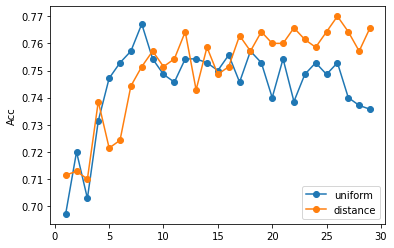

In [20]:
cv = KFold(n_splits = 5, shuffle = True) # shuffle = False si hay dimensión temporal 
for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
       for train_fold, test_fold in cv.split(train):
          # División train test aleatoria
          f_train = train.loc[train_fold]
          f_test = train.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['target'], axis=1), 
                               y = f_train['target'])
          y_pred = knn.predict(X = f_test.drop(['target'], axis = 1))
          # evaluación del modelo
          acc = accuracy_score(f_test['target'], y_pred)
          fold_accuracy.append(acc)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')      
    

plt.legend()
plt.show() 